In [1]:
# import libraries and check versions
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
GPU present


2021-10-01 09:12:27.061337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 09:12:27.086848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 09:12:27.087119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Data Importing and Wrangling

In [2]:
# import dataset
import pickle
dataset = pickle.load(open('./datasets/RML2016.10a_dict.pkl', 'rb'), encoding='latin1')

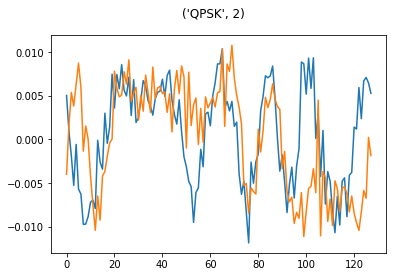

In [3]:
# plot dataset example
dataset_keys = list(dataset.keys())
x, y = dataset[dataset_keys[0]][1]

plt.figure(1)
plt.plot(x)
plt.plot(y)

plt.suptitle(dataset_keys[0])

plt.show()

In [4]:
# process raw data into usable format
columns = ['signal_type', 'SNR', 'samples']

# split dataset into individual records
temp = []
for k, v0 in dataset.items():
    data = [[k[0], k[1], v1] for v1 in v0]
    temp += data
    
# turn transformed data into dataframe
df = pd.DataFrame(temp, columns = columns)

# process dtypes of columns in dataframe
df = df.astype({'signal_type' : 'string'})

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   signal_type  220000 non-null  string
 1   SNR          220000 non-null  int64 
 2   samples      220000 non-null  object
dtypes: int64(1), object(1), string(1)
memory usage: 5.0+ MB
None


,signal_type,SNR,samples
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126..."
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ..."
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0..."


## Data Preparation for Training

In [5]:
# generate signal tags for classification
signal_tags = {st : tag for tag, st in enumerate(sorted(df['signal_type'].unique()))}

tag_list = [signal_tags[i] for i in df['signal_type'].values]
df['tag'] = tag_list

df

,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9
3,QPSK,2,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",9
4,QPSK,2,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",9
...,...,...,...,...
219995,BPSK,-18,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",3
219996,BPSK,-18,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",3
219997,BPSK,-18,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",3
219998,BPSK,-18,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",3


In [6]:
# extract 10 rows from each signal type for testing
df_train = df.copy()
df_test = pd.DataFrame([], columns = columns)

for st in df['signal_type'].unique():
    for snr in df['SNR'].unique():
        sample = df[df['signal_type'] == st][df['SNR'] == snr][:10]
        
        
        df_test = df_test.append(sample, ignore_index=True)        
        df_train.drop(sample.index.values, inplace=True)
        
df_test = df_test.astype({'tag' : 'int8'})

df_test

/tmp/ipykernel_6562/2130733282.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = df[df['signal_type'] == st][df['SNR'] == snr][:10]


,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9
3,QPSK,2,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",9
4,QPSK,2,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",9
...,...,...,...,...
2195,BPSK,-14,"[[-0.0022792828, 0.0065565617, -0.0040618107, ...",3
2196,BPSK,-14,"[[-0.002138951, 0.0027870536, -0.0056979167, 0...",3
2197,BPSK,-14,"[[0.010227201, -0.0013599384, 0.00039103237, -...",3
2198,BPSK,-14,"[[0.0008560782, 0.00785923, 0.00017260351, -0....",3


In [7]:
# scramble training dataset
df_train = df_train.sample(frac=1)

df_train

,signal_type,SNR,samples,tag
124196,QAM64,0,"[[-0.007524667, -0.0069203987, -0.00553178, -0...",8
154671,BPSK,-8,"[[-0.0054594576, -0.010008992, -0.0077598416, ...",3
126297,AM-SSB,-20,"[[0.008518201, -0.0063941902, -0.006118814, -0...",2
58417,AM-SSB,-2,"[[0.0012507342, -0.005536368, -2.7053993e-05, ...",2
132035,WBFM,-10,"[[0.006541209, 0.008298725, -0.011809105, 0.00...",10
...,...,...,...,...
140844,AM-SSB,14,"[[-0.0016601891, -0.008794876, -0.0076665343, ...",2
80893,WBFM,12,"[[0.0011176013, 0.00094249955, 0.0008594677, 0...",10
49965,BPSK,14,"[[-0.0011566691, -0.0022202588, -0.0033629988,...",3
198144,CPFSK,4,"[[-0.0051603215, -0.0024407639, -0.0026219739,...",4


In [8]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

In [9]:
# extract train and test data
X_train = np.concatenate(df_train['samples'].values).reshape((df_train.shape[0], 2, 128))
y_train = one_hot(df_train['tag'].values, 11)

X_test = np.concatenate(df_test['samples'].values).reshape((df_test.shape[0], 2, 128))
y_test = one_hot(df_test['tag'].values, 11)

## Model Training and Testing

In [28]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, Dropout, AveragePooling2D, concatenate, ReLU, Dense, Input

In [38]:
# functions to create Inception-ResNet sections
def stem(x):
    x = Conv2D(32, (1, 3), strides=2)(x)
    x = Conv2D(32, (1, 3))(x)
    x = Conv2D(64, (1, 3), padding='same')(x)
    x = MaxPooling2D((1, 3), strides=2, padding='same')(x)
    x = Conv2D(80, 1)(x)
    x = Conv2D(192, (1, 3))(x)
    x = Conv2D(192, (1, 3), strides=2, padding='same')(x)

    return x

def res_incep_A(x, n_modules):
    for _ in range(n_modules):
        x = ReLU()(x)
        
        # parallel paths
        a = Conv2D(32, 1)(x)

        b = Conv2D(32, 1)(x)
        b = Conv2D(32, (1, 3))(b)

        c = Conv2D(32, 1)(x)
        c = Conv2D(48, 3)(c)
        c = Conv2D(64, 3)(c)

        # converge parallel paths
        converge = concatenate([a, b, c])
        converge = Conv2D(320, 1)(converge)

        # skip-con
        x = concatenate([x, converge])
        x = ReLU()(x)
    
    return x

def res_incep_B(x, n_modules):
    for _ in range(n_modules):
        x = ReLU()(x)
        
        # parallel paths
        a = Conv2D(192, 1)(x)

        b = Conv2D(128, 1)(x)
        b = Conv2D(160, (1, 7))(b)
        b = Conv2D(192, (7, 1))(b)

        # converge parallel paths
        converge = concatenate([a, b])
        converge = Conv2D(1088, 1)(converge)

        # skip-con
        x = concatenate([x, converge])
        x = ReLU()(x)
    
    return x

def res_incep_C(x, n_modules):
    for _ in range(n_modules):
        x = ReLU()(x)
        
        # parallel paths
        a = Conv2D(192, 1)(x)

        b = Conv2D(192, 1)(x)
        b = Conv2D(224, (1, 7))(b)
        b = Conv2D(256, (7, 1))(b)

        # converge parallel paths
        converge = concatenate([a, b])
        converge = Conv2D(1536, 1)(converge)

        # skip-con
        x = concatenate([x, converge])
        x = ReLU()(x)
    
    return x

In [32]:
# create main model
def create_model(in_dim, out_dim):
    '''
    function used to create Inception-ResNet RF model.

    INPUT PARAMETERS
    in_dim: dimensions of input layer
    
    out_dim: dimensions of output layer
    '''
    input_layer = Input(in_dim)

    print(input_layer.shape.dims)
    
    stem_block = stem(input_layer)

    print(stem_block.shape.dims)

    # block A
    a = res_incep_A(stem_block, 10)
    a = Conv1D(1088, 1)(a)

    # block B
    b = res_incep_B(a, 20)
    b = Conv1D(2080, 1)(b)

    # block C
    c = res_incep_C(b, 10)

    # rest of model
    x = AveragePooling2D()(c)
    x = Dropout(0.2)(x)

    # output
    x = Dense(out_dim, activation='softmax')(x)

    # put model together
    model = Model(inputs=input_layer, outputs=x, name='rf_classification_model')

In [39]:
# create model
model = create_model((2, 128, 1), 11)

tf.keras.utils.plot_model(model, show_shapes=True)

[Dimension(None), Dimension(2), Dimension(128), Dimension(1)]
[Dimension(None), Dimension(1), Dimension(15), Dimension(192)]


ValueError: Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_117/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_117/Conv2D/ReadVariableOp)' with input shapes: [?,1,15,32], [3,3,32,48].